In [181]:
import pandas as pd

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [182]:
import cleaning_functions as clean

In [183]:
data = pd.read_csv('Code_challenge_train.csv')

In [184]:
data.shape

(40000, 101)

In [185]:
data.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-17.933519,6.559220,2.422468,-27.737392,-12.080601,-3.892934,1.067466,0.935953,10.912007,1.107144,...,11.107047,0.093337,asia,0.421524,35.259947,8.994318,-21.000182,-0.686588,2.949106,1
1,-37.214754,10.774930,5.404072,21.354738,0.612690,-3.093533,6.161558,-0.972156,-5.222169,0.384969,...,-1.991846,15.666187,asia,-0.132764,-1.192563,3.885024,-37.886523,-7.730392,-1.107330,0
2,0.330441,-19.609972,-1.331804,-15.153892,19.710240,19.077300,-1.747110,0.545570,-1.464609,3.670570,...,17.132840,-5.333012,asia,1.432308,-3.435427,-1.133450,7.426099,-5.945534,1.316312,0


In [186]:
data = clean.cleaning(data)

In [187]:
data.shape

(40000, 115)

In [188]:
nulls = data.isnull().sum().to_frame()
nulls.loc[nulls[0] != 0, :]

,0


In [189]:
data.head(3)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x34_tesla,x34_volkswagon,x35_friday,x35_monday,x35_thursday,x35_tuesday,x35_wednesday,x93_america,x93_asia,x93_euorpe
0,-17.933519,6.559220,2.422468,-27.737392,-12.080601,-3.892934,1.067466,0.935953,10.912007,1.107144,...,0,0,0,0,1,0,0,0,1,0
1,-37.214754,10.774930,5.404072,21.354738,0.612690,-3.093533,6.161558,-0.972156,-5.222169,0.384969,...,0,0,0,0,0,0,1,0,1,0
2,0.330441,-19.609972,-1.331804,-15.153892,19.710240,19.077300,-1.747110,0.545570,-1.464609,3.670570,...,0,0,0,0,1,0,0,0,1,0


***
### Exploring Correlations

In [190]:
def make_heat_map(df = data):
    """
    Plots the heatmap of correlations of the given df
    """
    import seaborn as sns
    import numpy as np

    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize = (25,25))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(df.corr(), mask = mask, vmin = -1, vmax = 1, cmap = cmap);

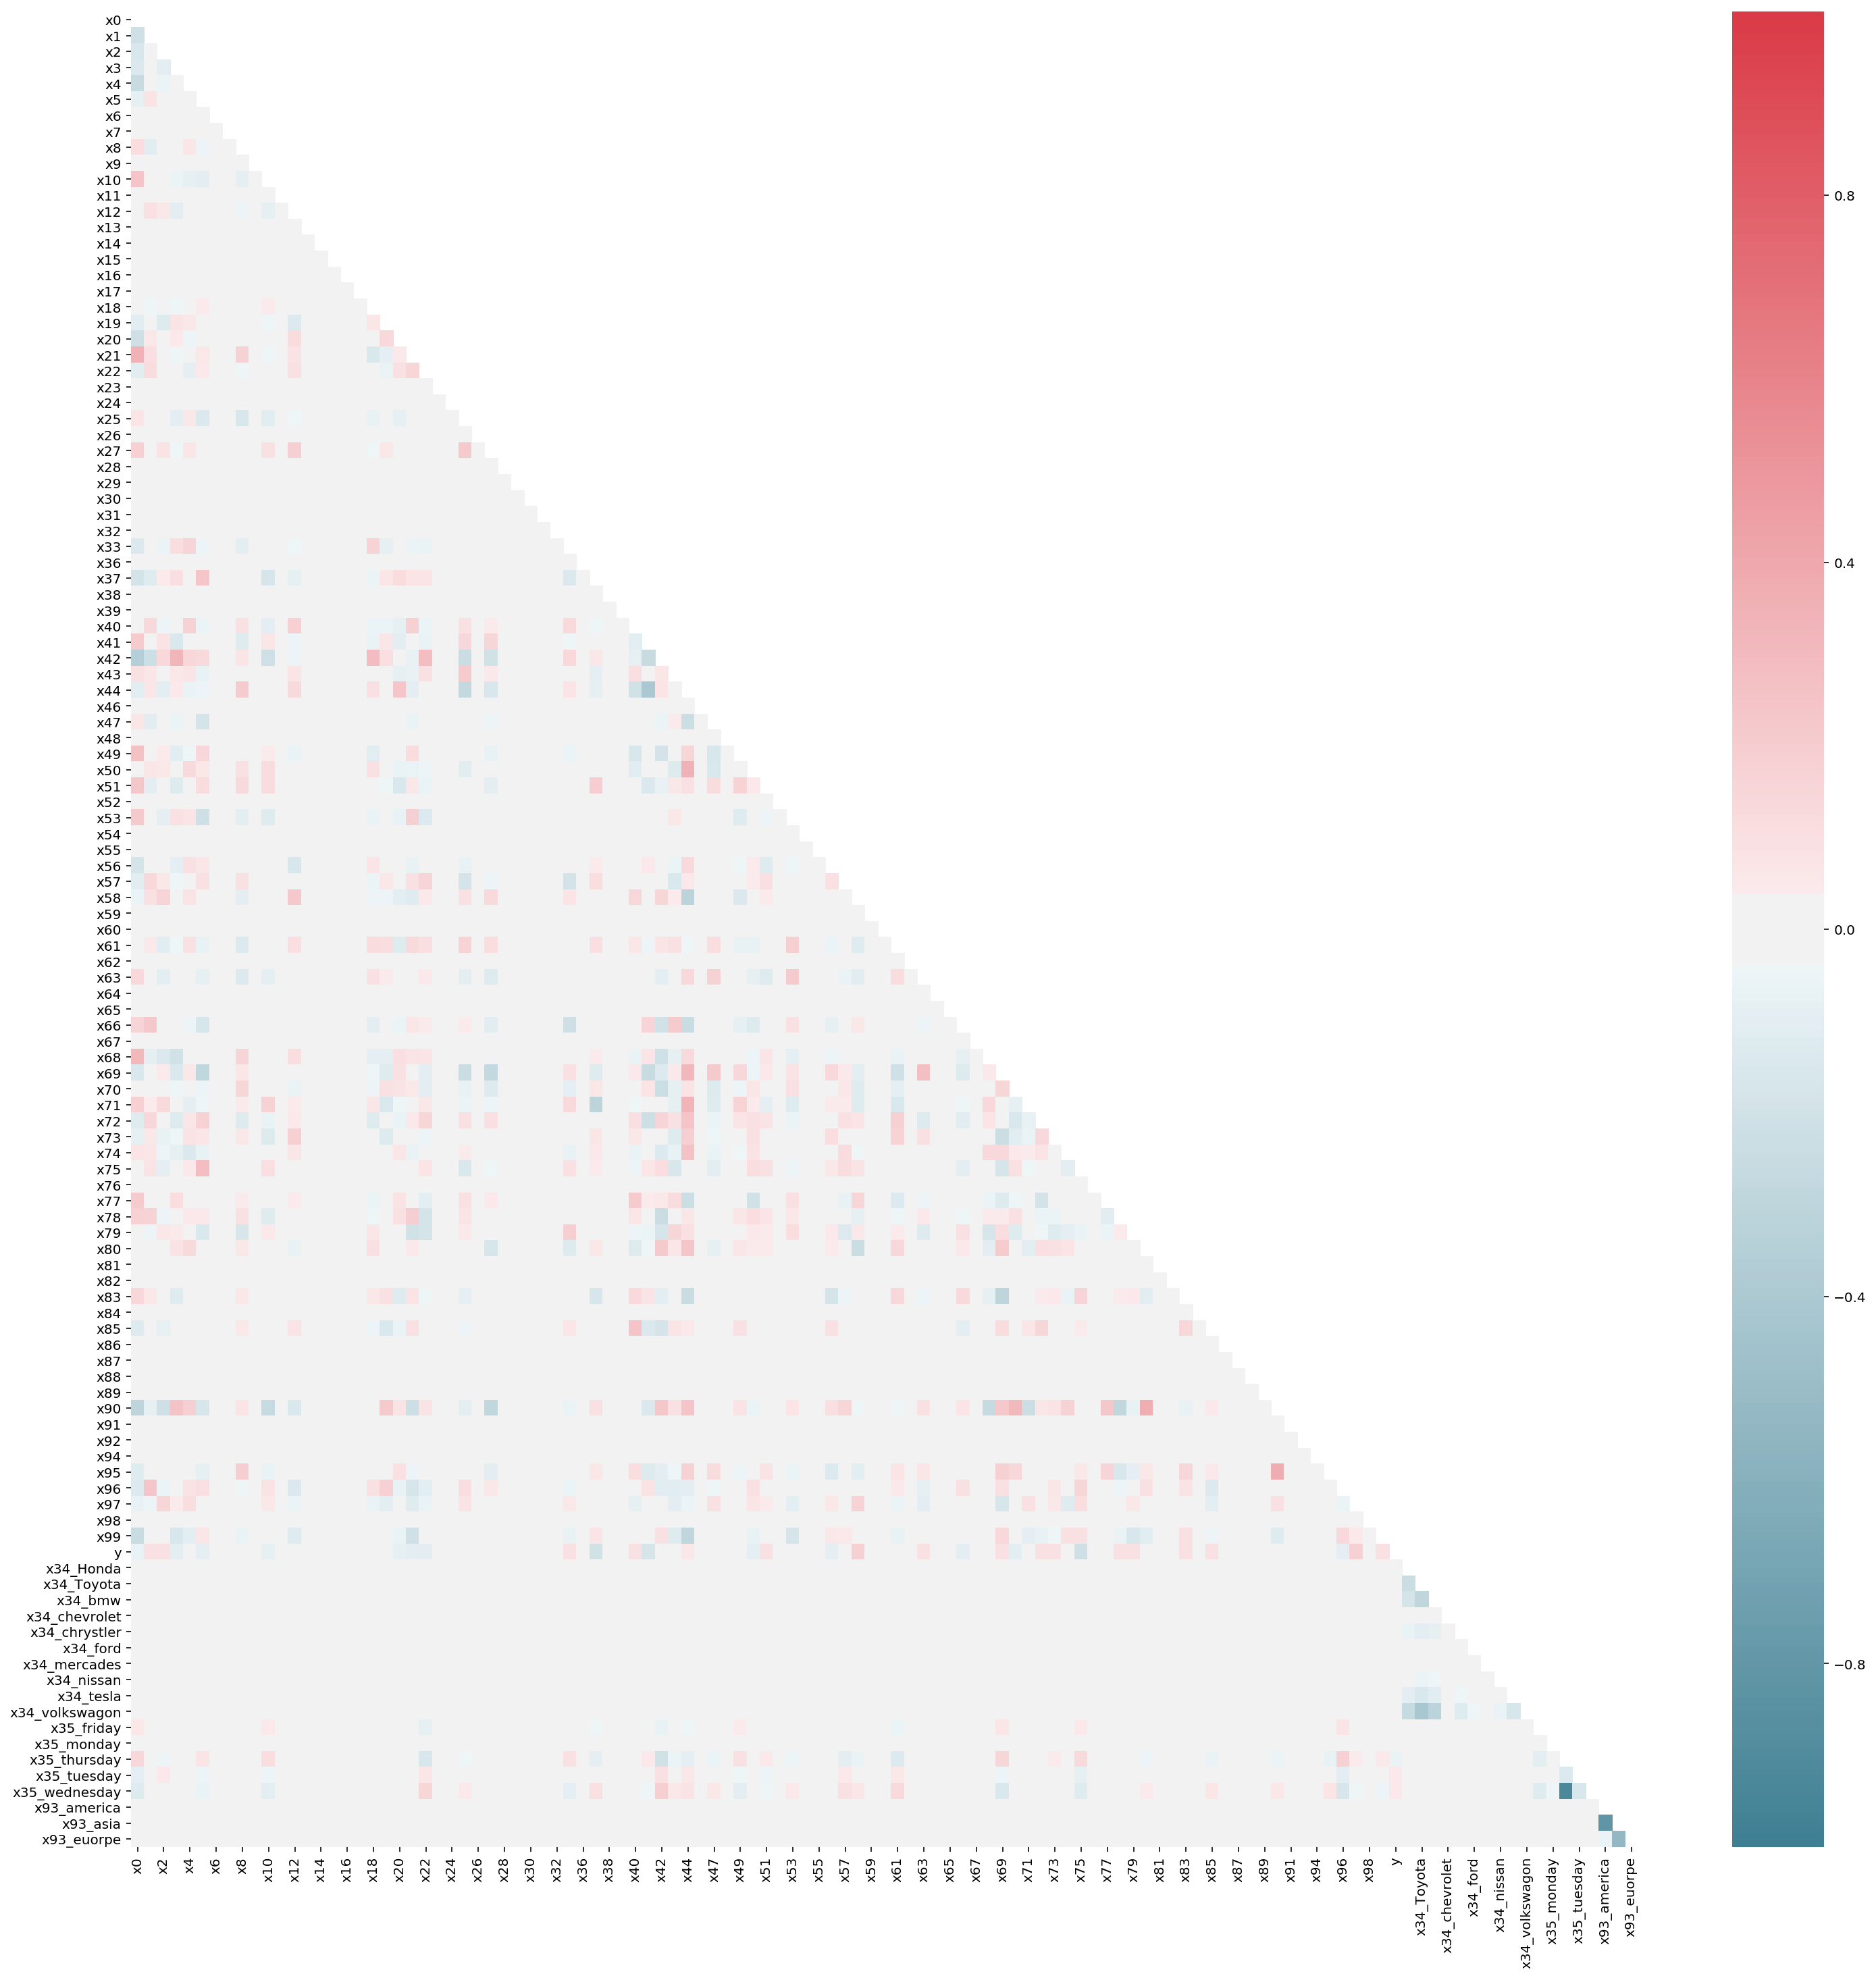

In [191]:
make_heat_map(data);

Observations: <br />
No strong linear correlations with the target variable, or within the variables. But that doesn't mean there is no correlation at all, there might be non-linear relationships. I will see later if I have squared relationships between the target variable, and the second degree variables, and their interactions. <br />
At least, it is good to know there's no multi-collinearity in the dataset, meaning I don't need to use Principal Component Analysis, as it is not a good fit for this dataset. 

The colinearity between the one-hot encoded variables of the same original one is expected, and doesn't affect what I observed.

**Creating a testing set to measure performance of models, and continue with the explorations**

In [192]:
data['y'].value_counts()

0    31880
1     8120
Name: y, dtype: int64

In [193]:
data['y'].value_counts(normalize = True)

0    0.797
1    0.203
Name: y, dtype: float64

In [194]:
from sklearn.model_selection import train_test_split

X = data.drop('y', axis = 1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 72019)

In [195]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [196]:
poly = PolynomialFeatures(degree = 2, interaction_only = False)

In [197]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [198]:
X_train_poly.shape

(30000, 6670)

In [199]:
corr_poly = pd.DataFrame(X_train_poly).corrwith(y)

In [200]:
correlations = corr_poly.to_frame(name = 'poly_corrs')

In [201]:
correlations['abs_value'] = correlations['poly_corrs'].abs()

In [202]:
correlations.sort_values(by = 'abs_value', ascending = False).head()

,poly_corrs,abs_value
2820,0.021882,0.021882
1137,-0.021647,0.021647
3373,-0.021641,0.021641
1697,-0.020895,0.020895
6176,-0.020552,0.020552


That wouldn't add any explanatory value to the model, because correlations with y still almost don't exist

In [203]:
data.select_dtypes(include='object').shape
# we have all numeric variables now, and we are set to train models in the next notebook

(40000, 0)

So far, and next steps: <br />
We have very imbalanced classes, instead of upping the positive class, or down-sampling the negative class. I'm gonna try SVM, Random Forests and XGBoost, although I know already that XGBoost will perform best. <br />
Measures: AUC. I will add f1-score and confusion matrix for a full picture.

***
### Some visualizations

going back to before one-hot encoding, because I want to group mean of y based on the string variables. I want to see if there's some sort of pattern. If for specific makes in a certain content, for example, are more label 1, etc.

In [207]:
def weekdays(v):
    """
    This is a supporting function to cleaning(), to be used inside the latter. 
    Meant to be applied to each value of the weekdays variable.
    """
    if 'wed' in v:
        v = 'wednesday'
    elif 'thu' in v:
        v = 'thursday'
    elif 'fri' in v:
        v = 'friday'
        
    return v


# Combining all cleaning steps in a function
def cleaning(data):
    """
    This function is specific to 'Code_challenge_train.csv' and 'Code_challenge_test.csv'
    
    Parameters:
    -----------
    data: the data frame to clean. 
    """
    # numerical variables with strange characters and nulls: replace missing value with '9999'
    data[['x41', 'x45']] = data[['x41', 'x45']].fillna('9999')
    
    # strip the strange characters, and replace
    data['x41'] = data['x41'].map(lambda x: x.strip('$'))
    data['x45'] = data['x45'].map(lambda x: x.strip('%'))
    data[['x41', 'x45']] = data[['x41', 'x45']].astype('float')
    
    # filling nulls in rest of string variables with 'unknown'
    object_columns = data.select_dtypes(include='object').columns.to_list()
    data[object_columns] = data[object_columns].fillna('unknown')
    
    # weekdays variable is messy, cleaning it
    data['x35'] = data['x35'].map(lambda x: weekdays(x))
    
    # dropping 'x45'
    data.drop(['x45'], axis = 1, inplace = True)
    
    # changing months to numbers
    months_dict = {'January': 1, 'Feb': 2, 'Mar':3, 'Apr': 4, 'May': 5, 'Jun': 6, 'July': 7, 'Aug': 8, 'sept.': 9, 
                    'Oct': 10, 'Nov': 11, 'Dev': 12, 'unknown': 0}
    data['x68'] = data['x68'].map(months_dict)
    
#     # one-hot encode the other string variables
#     string_variables = data.select_dtypes(include='object').columns.to_list()
#     string_dummies = pd.get_dummies(data[string_variables])
#     data = pd.concat([data, string_dummies], axis = 1, sort = False)
    
#     # dropping extra columns
#     unknowns_columns = [n for n in data.columns if 'unknown' in n]
#     data.drop(unknowns_columns, axis = 1, inplace = True)
#     data.drop(['x34', 'x35', 'x93'], axis = 1, inplace = True)
    
    # filling missing values in the numerical variables
    numerical_columns = data.select_dtypes(exclude = 'object').columns.to_list()
    data[numerical_columns] = data[numerical_columns].fillna(method = 'bfill')
    
    return data

In [208]:
data = pd.read_csv('Code_challenge_train.csv')

In [209]:
data = cleaning(data)

In [210]:
data.select_dtypes(include='object').head(1)

,x34,x35,x93
0,bmw,thursday,asia


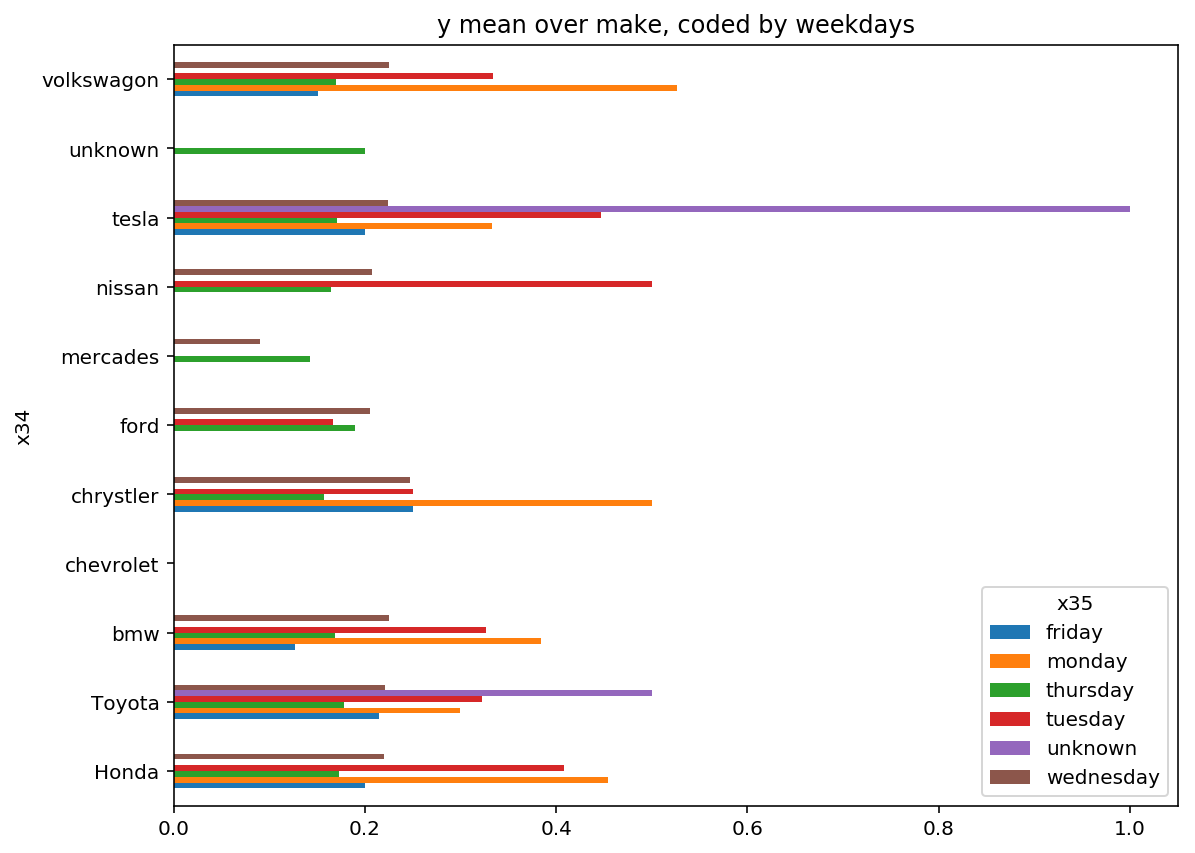

In [211]:
data.groupby(['x34', 'x35'])['y'].mean().unstack().plot(kind = 'barh', figsize = (9,7), 
                                                       title = 'y mean over make, coded by weekdays');

Not all visualizations are going to be insightful. for example, this one tells me that a lot of Tesla on some unknown day, are labeled 1. <br />
of course knowing the dictionary of the data, and what each variable means, I can draw better conclusions

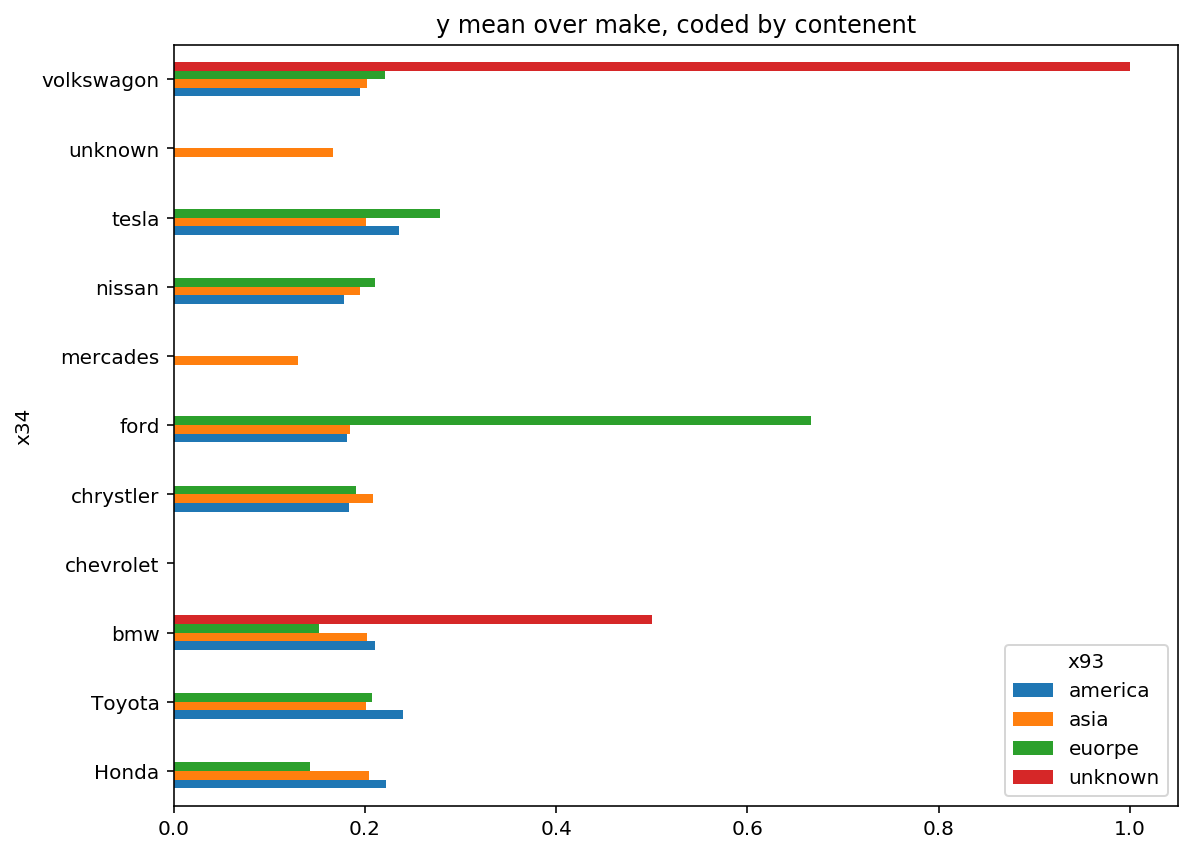

In [212]:
data.groupby(['x34', 'x93'])['y'].mean().unstack().plot(kind = 'barh', figsize = (9,7), 
                                                       title = 'y mean over make, coded by contenent');

Same issue here. Volkswagon in some unknown contenent was labeled 1 a lot. Followed by Ford in Europe, and BMW in some unknown contenent.

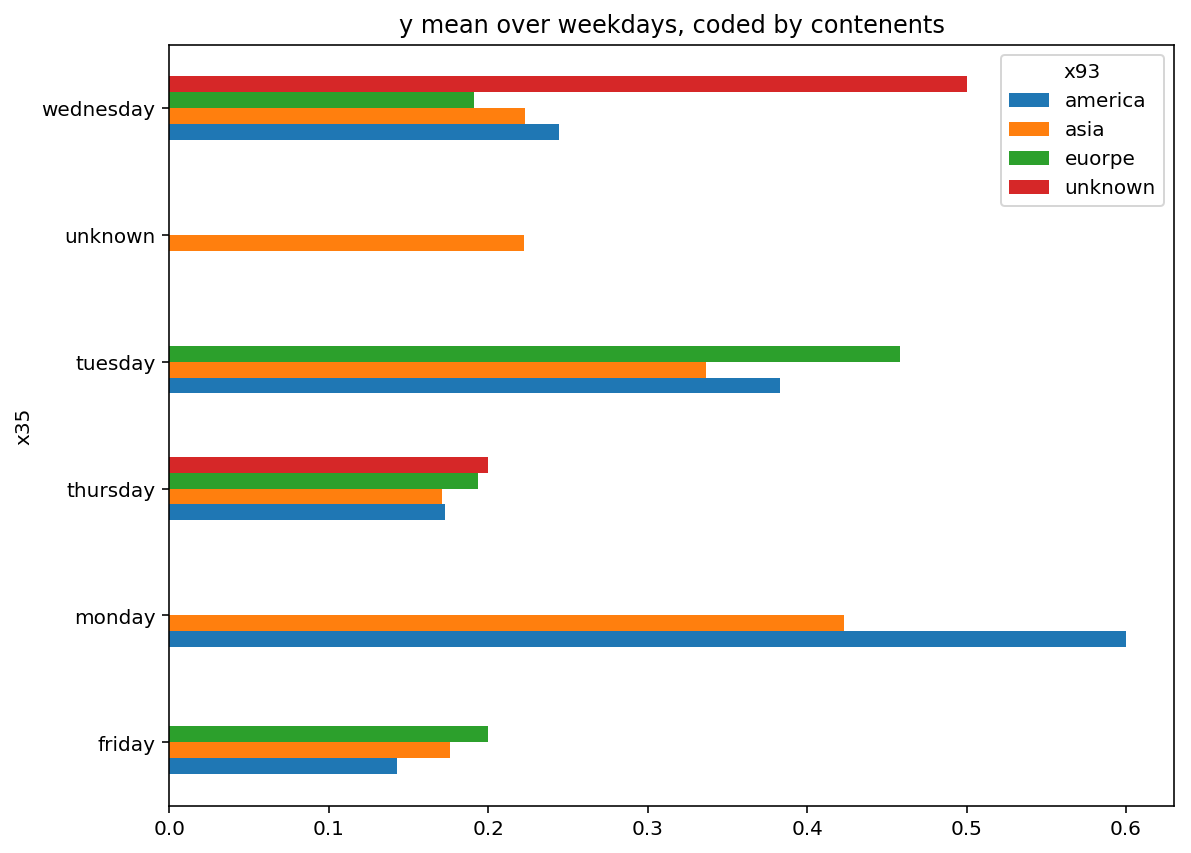

In [213]:
data.groupby(['x35', 'x93'])['y'].mean().unstack().plot(kind = 'barh', figsize = (9,7), 
                                                       title = 'y mean over weekdays, coded by contenents');

America on Mondays and Tuesdays was labeled 1 more often than 0, followed by Europe on Tuesdays

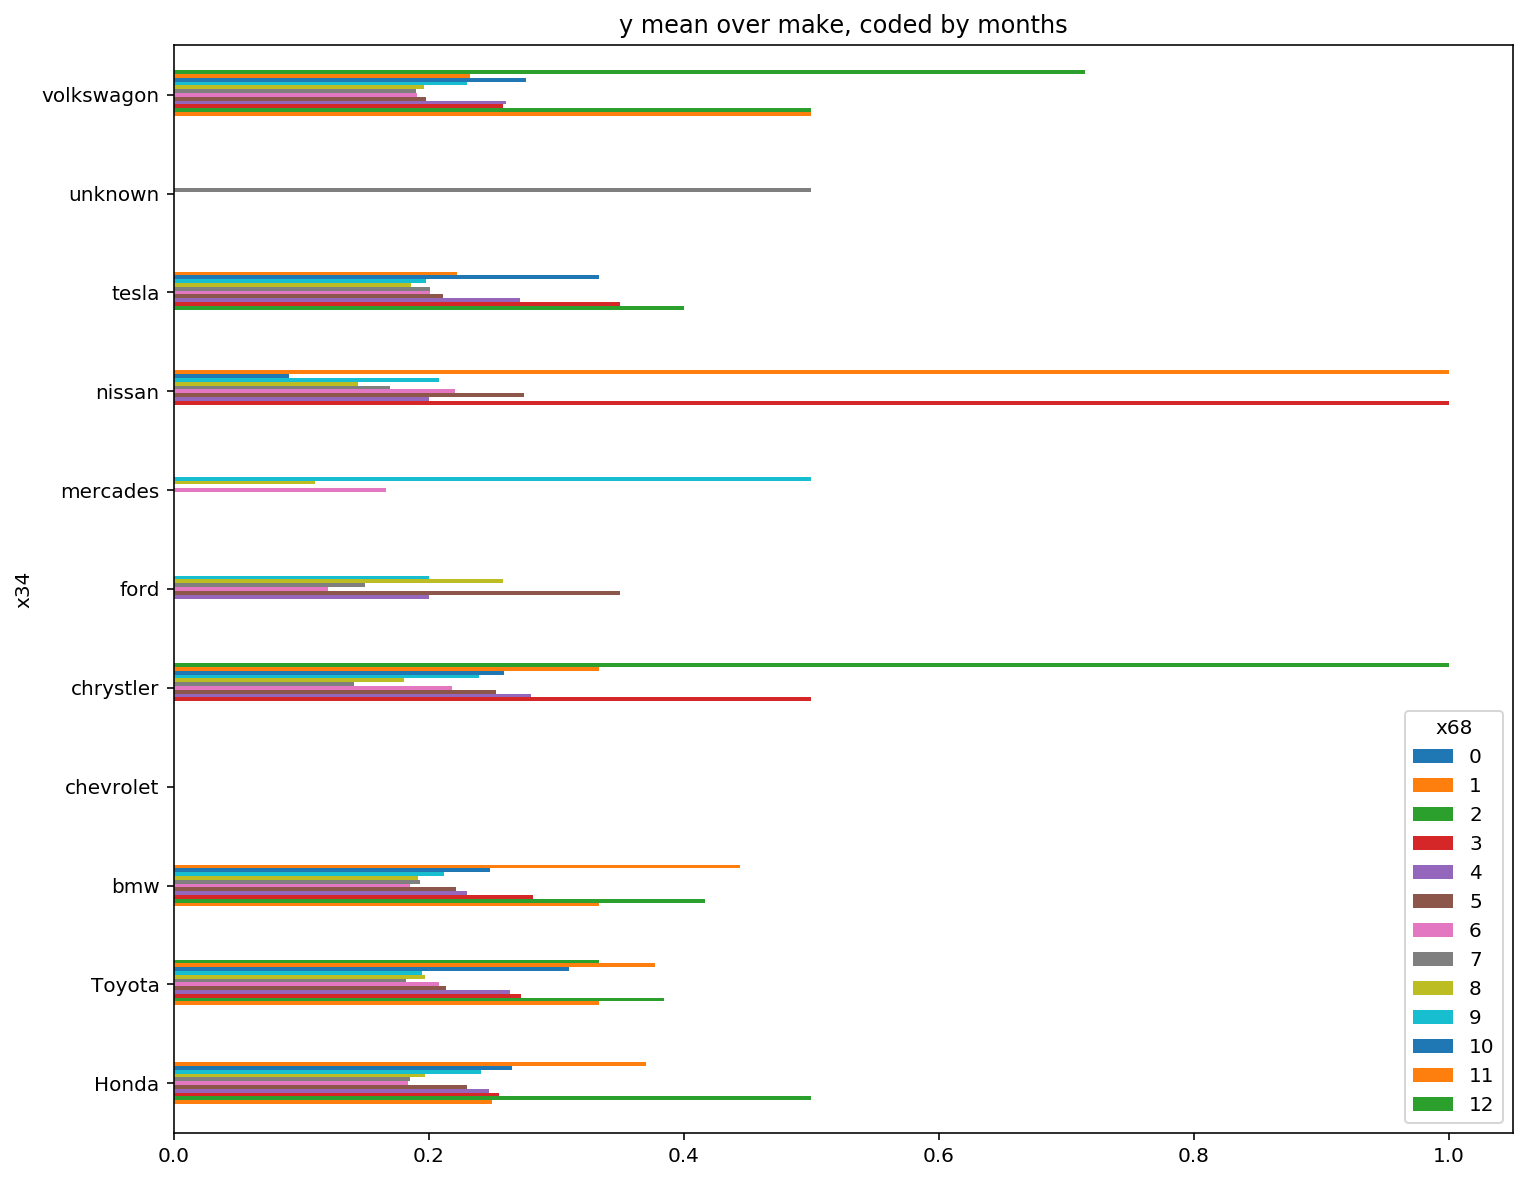

In [214]:
data.groupby(['x34', 'x68'])['y'].mean().unstack().plot(kind = 'barh', figsize = (12,10), 
                                                       title = 'y mean over make, coded by months');

This is a hard to read plot, making it not particularly a good one. Although we can tell clearly on first scan, is that Nissan was labeled 1 a whole lot in January, and March, followed by Chrystler in February, then Volkswagon in Feb. as well

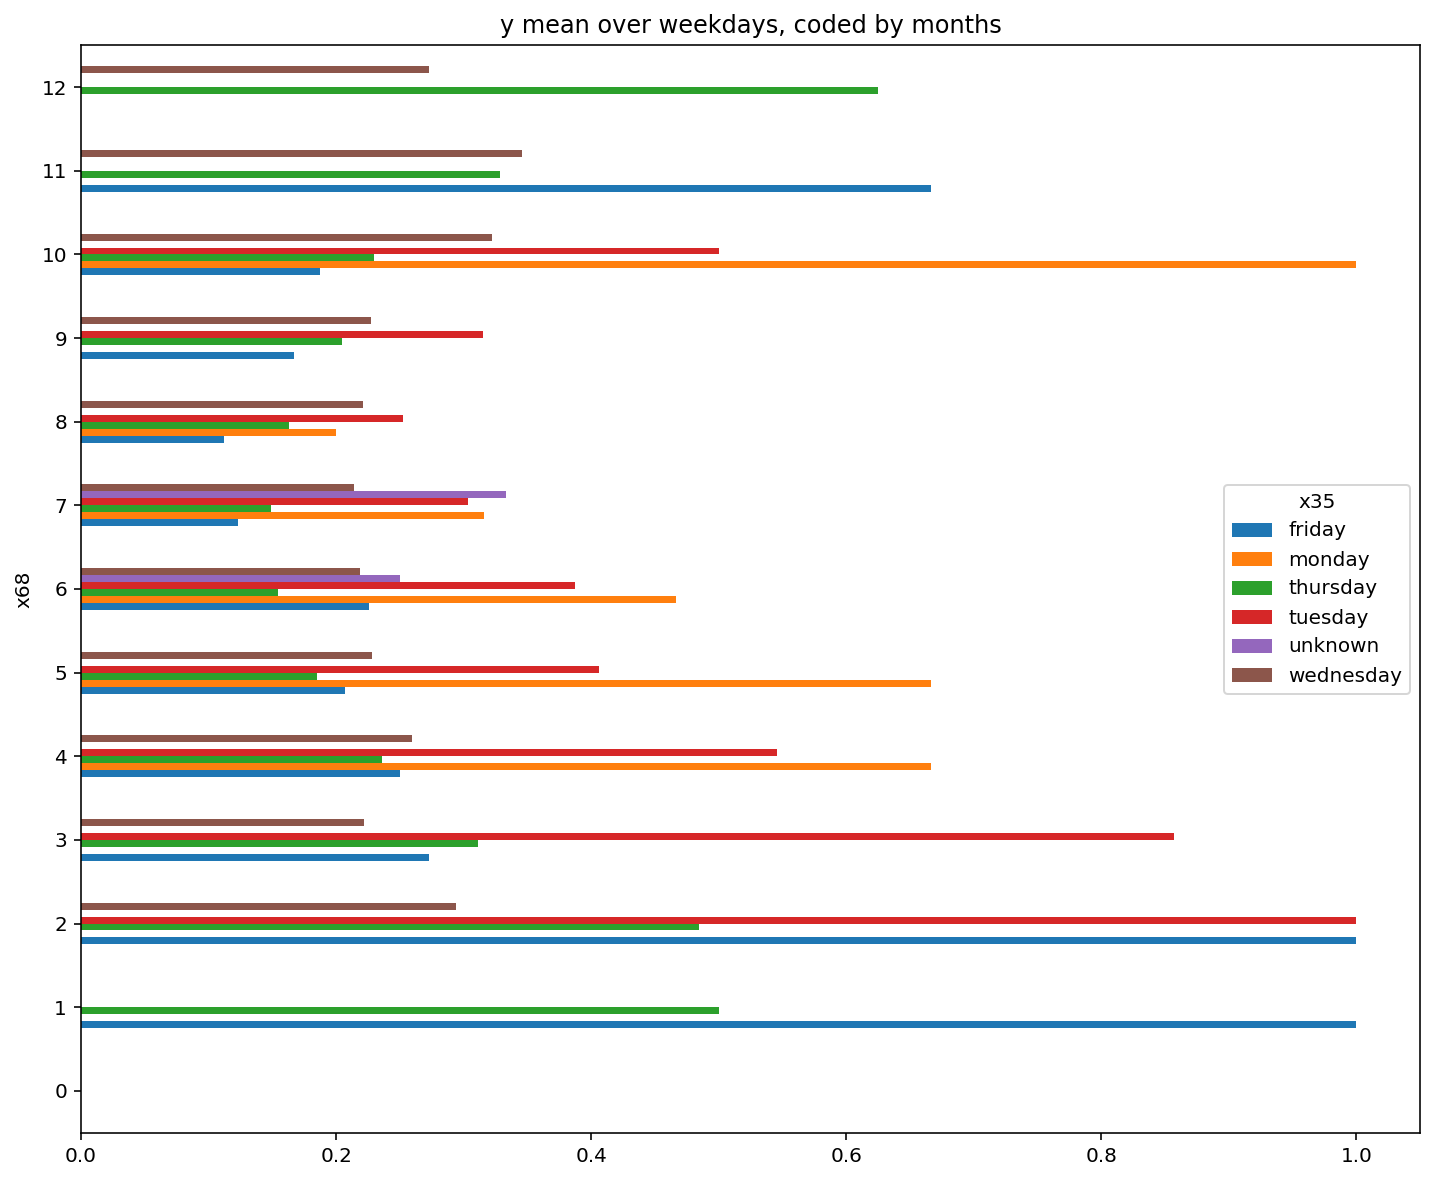

In [215]:
data.groupby(['x68', 'x35'])['y'].mean().unstack().plot(kind = 'barh', figsize = (12,10), 
                                                       title = 'y mean over weekdays, coded by months');

More positive labels occured on Fridays during January and February, on Mondays during October. On Tuesdays during Feb and March. The rest are either equally spread between the two labels, or more frequently belonged to the negative class.

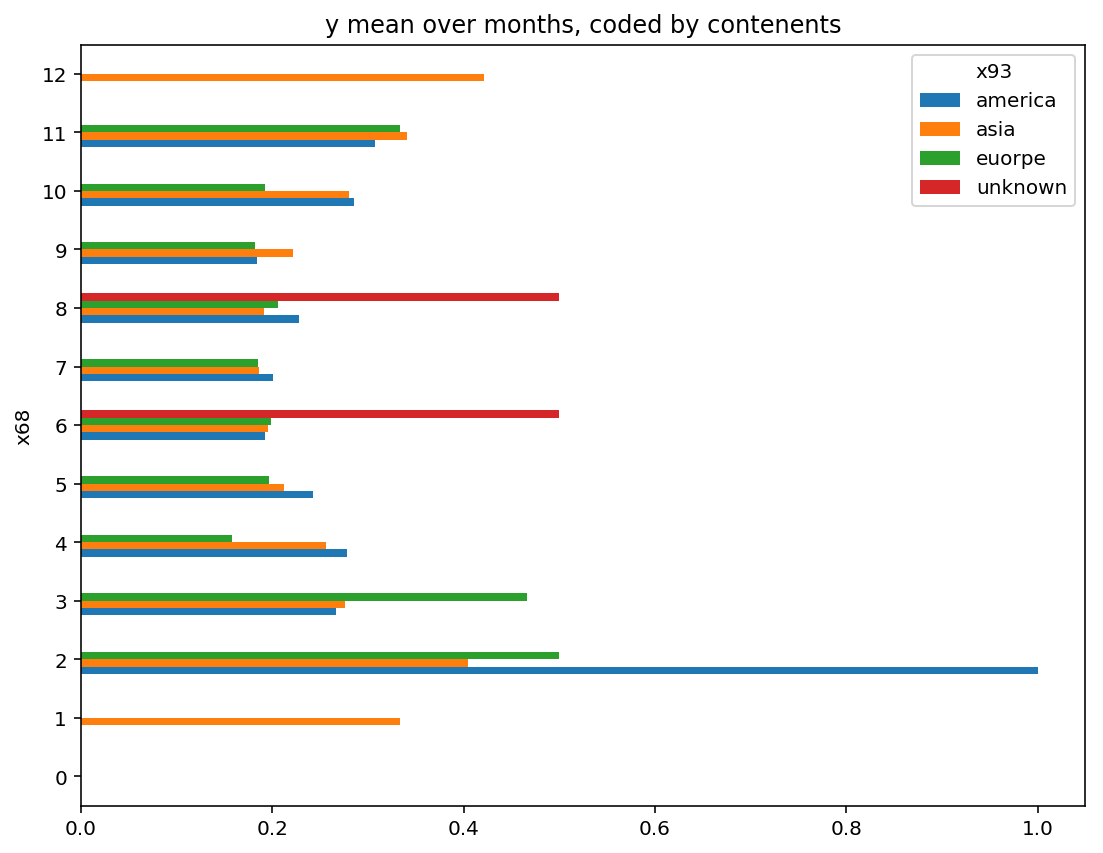

In [216]:
data.groupby(['x68', 'x93'])['y'].mean().unstack().plot(kind = 'barh', figsize = (9,7), 
                                                       title = 'y mean over months, coded by contenents');

One stands out, America in February has more positive class by a big difference than all the rest.

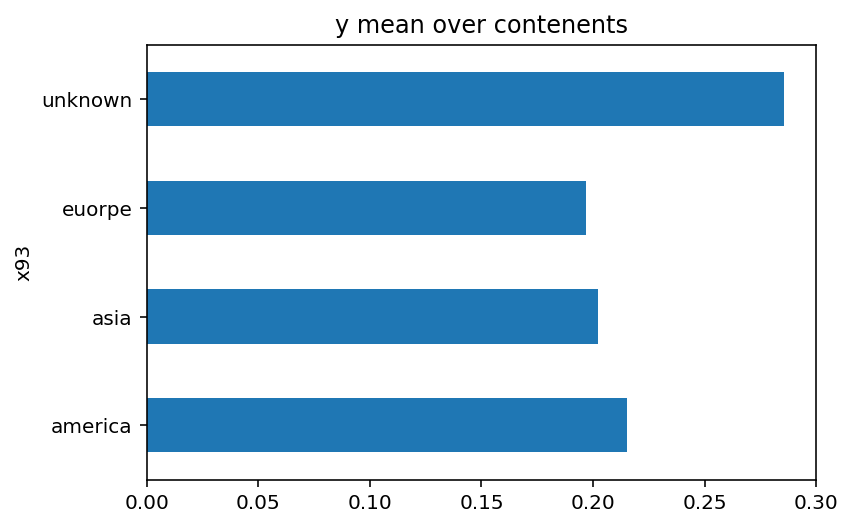

In [217]:
data.groupby(['x93'])['y'].mean().plot(kind = 'barh', title = 'y mean over contenents');

Individually speaking, the contents shared almost the same frequency between the two classes, holding everything else fixed. 

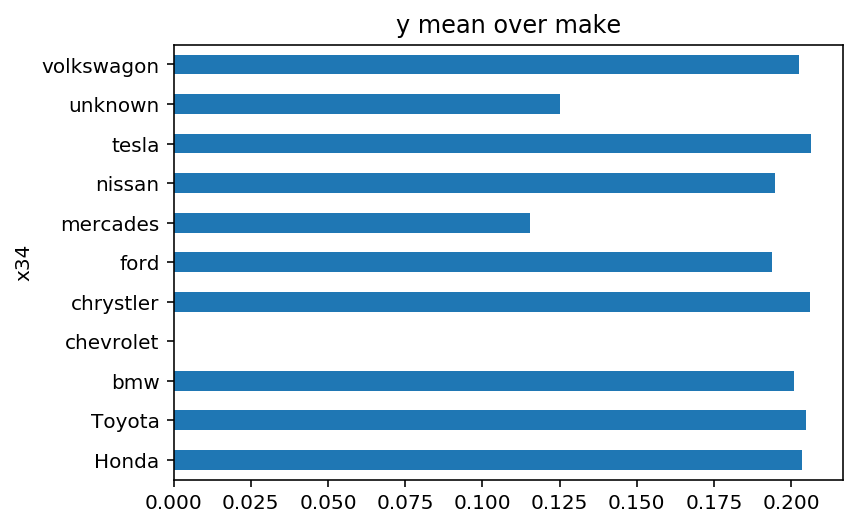

In [218]:
data.groupby(['x34'])['y'].mean().plot(kind = 'barh', title = 'y mean over make');

Same conclusion for car make

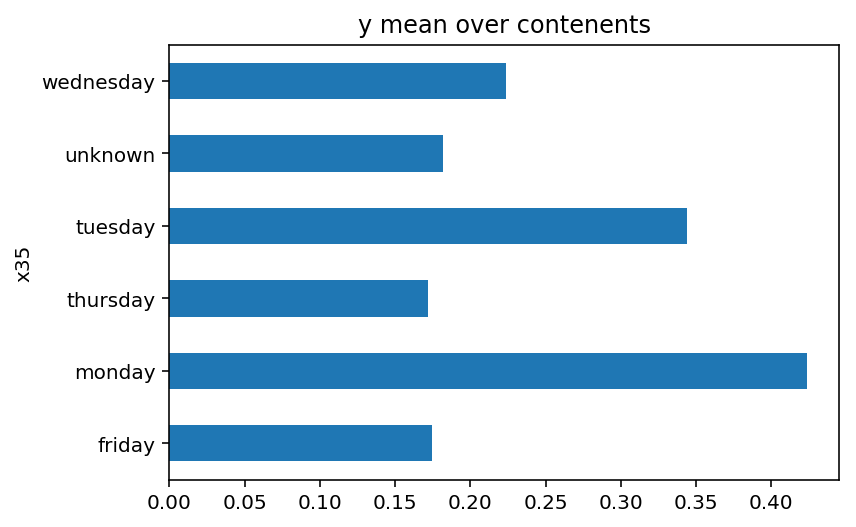

In [219]:
data.groupby(['x35'])['y'].mean().plot(kind = 'barh', title = 'y mean over contenents');

We can see some distinctions here, beginning of the week has more positive class labels than the rest of the week. 

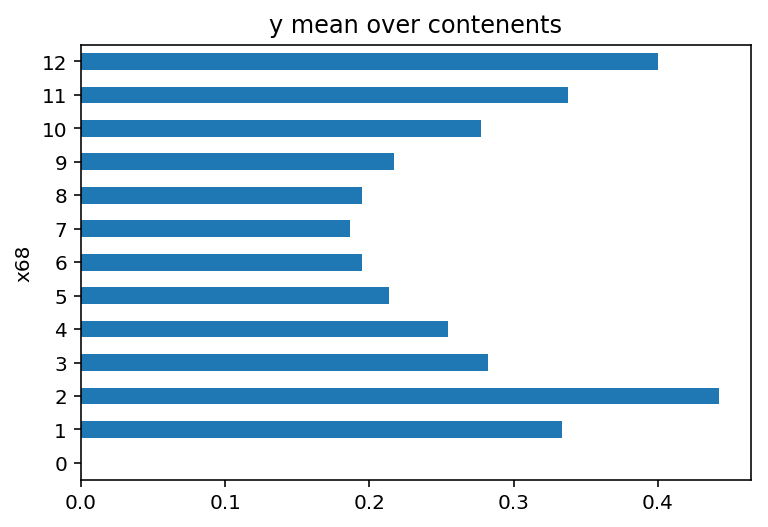

In [220]:
data.groupby(['x68'])['y'].mean().plot(kind = 'barh', title = 'y mean over contenents');

There's seasonality in this data. More cases (observations) carry the negative label during summer, and picks up during winter months, specifically February and December, were observations caried the positive label more frequenlty.